In [35]:
import numpy as np
import matplotlib.pyplot as plt
import numba
import scipy.integrate as spint
import cmath
# plt.style.use('seaborn-pastel')
plt.rcParams['font.family'] = 'sans-serif'
COLOR = 'w'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['axes.edgecolor'] = 'k'
SIZE = 8
plt.rcParams['font.size'] = SIZE
plt.rcParams['legend.fontsize'] = SIZE
plt.rcParams['figure.titlesize'] = SIZE
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 800
# plt.rcParams['image.cmap'] = 'coolwarm'
plt.rcParams['image.cmap'] = 'viridis'

res = 200
MC_N = int(1e3)
MC_all = 0

# parameters

In [36]:
Delta_ZPL_0 = 406.83  # 406 THz  Meesala
lambda_SO_gs = 46e-3  # 46 GHz  Meesala
lambda_SO_es = 255e-3  # 255 GHz  Meesala

t_para = -1.7e3  # -1.7 PHz/strain  Meesala
t_perp = 0.078e3  # 0.078 PHz/strain   Meesala
d_gs = 1.3e3  # 1.3 PHz/strain   Meesala
d_es = 1.8e3  # 1.8 PHz/strain   Meesala
f_gs = -1.7e3  # -1.7 PHz/strain   Meesala
f_es = -3.4e3 # -3.4 PHz/strain   Meesala

sigma = 5e-4 # Kelsey
gamma_10 = 28e-3  # 28 GHz p.3 or 1.33 Ghz p.5 Smallwood PRL
# gamma_10 = 1e-4 # fwhm = 10e-3 Kelsey

poi = -0.2  # Poisson ratio of diamond, Kelsey

omega_t = np.linspace(406.1, 407.5, res)
omega_tau = np.linspace(-407.5, -406.1, res)

# omega_t = np.linspace(-0.5, 0.5, res)
# omega_tau = np.linspace(-0.5, 0.5, res)

# colorbar function

In [37]:
# @numba.jit
def colorbar(mappable, label='arb. units'):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    if label is not None:
        plt.ylabel(label)
    plt.sca(last_axes)
    return cbar

# creating mesh

In [38]:
omega_t_mesh, omega_tau_mesh = np.meshgrid(omega_t, omega_tau, indexing='xy')

# multiple plot function

In [39]:
# @numba.jit
def slices_plots(
    databox,
    titles=None,
    figure_shape=[4, 4],
    figure_size=(11, 10),
    vertical_gap=0.15,
    horizontal_gap=0.15,
    shared_x_label=r'Third-order frequency, $\nu_t$ (THz)',
    shared_x_label_x_position=0.515,
    shared_x_label_y_position=0.09,
    shared_y_label=r'First-order frequency, $\nu_\tau$ (THz)',
    shared_y_label_x_position=0.08,
    shared_y_label_y_position=0.5,
    shared_title=r'$\mathfrak{R} \left\{ \rho^{(3)}_{10,sig} (\omega_t, \omega_\tau) \right\}$',
    shared_title_x_position=0.515,
    shared_title_y_position=0.93,
    share_x_axis=True,
    share_y_axis=True,
    colorbar_labels='arb. units',
    EXTENT=(min(omega_t), max(omega_t), min(omega_tau), max(omega_tau))):

    fig, ax = plt.subplots(
        figure_shape[0],  # row
        figure_shape[1],  # column
        figsize=figure_size,
        sharex=share_x_axis,
        sharey=share_y_axis,
        gridspec_kw={
            "hspace": vertical_gap,
            'wspace': horizontal_gap
        })

    for i in range(np.shape(databox)[0]):
        im = ax.flatten()[i].imshow(databox[i],
                                    origin='lower',
                                    extent=EXTENT)
        ax.flatten()[i].set_title(titles[i])

        if np.size(colorbar_labels) == 1:
            if (i + 1) % figure_shape[1]:
                colorbar(im, None)
            else:
                colorbar(im, colorbar_labels)
        else:
            colorbar(im, colorbar_labels[i])

    fig.suptitle(x=shared_title_x_position,
                 y=shared_title_y_position,
                 t=shared_title,
                 ha='center',
                 size=1.5 * SIZE)

    if shared_x_label != None:  # shared x label
        fig.text(x=shared_x_label_x_position,
                 y=shared_x_label_y_position,
                 s=shared_x_label,
                 ha='center')

    if shared_y_label != None:  # shared y label
        fig.text(x=shared_y_label_x_position,
                 y=shared_y_label_y_position,
                 s=shared_y_label,
                 va='center',
                 rotation='vertical')

    plt.show()
    return fig

# complex square function

In [40]:
@numba.vectorize(
    [numba.float64(numba.complex128),
     numba.float32(numba.complex64)])
def abs2(x):

    return x.real**2. + x.imag**2.

# complex phase

In [41]:
@numba.vectorize(
    [numba.float64(numba.complex128),
     numba.float32(numba.complex64)])
def phase(x):

    return cmath.phase(x)

In [42]:
@numba.jit
def Delta_ZPL(eps_xx=0., 
              eps_yy=0., 
              eps_zz=0.):
    
    return Delta_ZPL_0 + t_para*eps_zz + t_perp*(eps_xx + eps_yy)

In [43]:
@numba.jit
def Delta_gs(eps_xx=0., 
             eps_yy=0., 
             eps_yz=0., 
             eps_xy=0., 
             eps_zx=0.):

    return np.sqrt(
        np.sum([
            lambda_SO_gs**2.,
            4. * (d_gs * (eps_xx - eps_yy) + f_gs * eps_yz)**2.,
            4. * (-2. * d_gs * eps_xy + f_gs * eps_zx)**2.
        ]))

In [44]:
@numba.jit
def Delta_es(eps_xx=0., 
             eps_yy=0., 
             eps_yz=0., 
             eps_xy=0., 
             eps_zx=0.):

    return np.sqrt(
        np.sum([
            lambda_SO_es**2.,
            4. * (d_es * (eps_xx - eps_yy) + f_es * eps_yz)**2.,
            4. * (-2. * d_es * eps_xy + f_es * eps_zx)**2.
        ]))

In [45]:
@numba.jit
def rho(omega_t,
        omega_tau,
        eps_xx=0.,
        eps_yy=0.,
        eps_zz=0.,
        eps_yz=0.,
        eps_xy=0.,
        eps_zx=0.):

    Del_ZPL = Delta_ZPL(eps_xx, eps_yy, eps_zz)

    Del_gs = Delta_gs(eps_xx, eps_yy, eps_yz, eps_xy, eps_zx)

    Del_es = Delta_es(eps_xx, eps_yy, eps_yz, eps_xy, eps_zx)

    amp = np.array(
        [0.0938, 0.0833, 0.0579, 0.0576,
         0.0709, 1.0000, 0.0799, 0.1521, 
         0.0631, 0.0837, 0.3036, 0.0737, 
         0.0522, 0.1212, 0.0581, 0.1228])
#     amp = np.array(
#         [0., 1., 1., 1., 
#          1., 1., 1., 1., 
#          1., 1., 1., 1., 
#          1., 1., 1., 1.])

    sign = np.array([[ 1.,  1.,  1.,  1.], 
                     [ 1.,  1.,  1., -1.], 
                     [ 1.,  1., -1.,  1.],
                     [ 1.,  1., -1., -1.], 
                     [ 1., -1.,  1.,  1.], 
                     [ 1., -1.,  1., -1.],
                     [ 1., -1., -1.,  1.], 
                     [ 1., -1., -1., -1.],
                     [-1.,  1.,  1.,  1.], 
                     [-1.,  1.,  1., -1.], 
                     [-1.,  1., -1.,  1.],
                     [-1.,  1., -1., -1.], 
                     [-1., -1.,  1.,  1.],
                     [-1., -1.,  1., -1.], 
                     [-1., -1., -1.,  1.],
                     [-1., -1., -1., -1.]])

    RHO = 1.j * np.zeros(np.shape(omega_t))

    for i in range(np.shape(sign)[0]):
        t_Lorentz = 1.j * np.sqrt(amp[i]) * gamma_10 / (
            omega_t - (Del_ZPL + sign[i, 0] * Del_gs + sign[i, 1] * Del_es -
                       1.j * gamma_10))
        tau_Lorentz = 1.j * np.sqrt(amp[i]) * gamma_10 / (
            omega_tau + (Del_ZPL + sign[i, 2] * Del_gs + sign[i, 3] * Del_es +
                         1.j * gamma_10))

        RHO += t_Lorentz * tau_Lorentz

    return RHO

In [46]:
@numba.jit
def Gaus(eps_ij):
    
    return 1. / sigma / np.sqrt(2. * np.pi) * np.exp(-eps_ij**2. / 2. / sigma**2.)

In [47]:
@numba.jit
def infint(func):
    
    return spint.quad_vec(func, -np.inf, np.inf)

In [48]:
@numba.jit
def tr_MCint(
        omega_t=omega_t,
        omega_tau=omega_tau,
        MC_N=MC_N  # MC Steps
):

    randn_eps_yy_0 = sigma * np.random.randn(MC_N)  # normal distribution

    I_tr = 1.j * np.zeros((res, res))

    if MC_N >= res**2:

        # looping over omega mesh, equivalent to the below, tends to be faster if MC_N > res^2
        for i, om_t in enumerate(omega_t):
            for j, om_tau in enumerate(omega_tau):
                I_tr[j, i] = np.mean(
                    rho(om_t,
                        om_tau,
                        eps_xx=poi*randn_eps_yy_0,
                        eps_yy=randn_eps_yy_0,
                        eps_zz=poi*randn_eps_yy_0))

    else:

        # looping over MC stemp, equivalent to the top, tends to be faster if MC_N < res^2
        for i in range(MC_N):
            I_tr += rho(omega_t_mesh,
                         omega_tau_mesh,
                         eps_xx=poi*randn_eps_yy_0[i],
                         eps_yy=randn_eps_yy_0[i],
                         eps_zz=poi*randn_eps_yy_0[i])
            
    return I_tr

In [49]:
if MC_all:
    
    I_tr = tr_MCint()
    
else:

    func = lambda eps_yy_0: Gaus(eps_yy_0) * rho(omega_t_mesh, 
                                                 omega_tau_mesh, 
                                                 eps_xx=poi*eps_yy_0,
                                                 eps_yy=eps_yy_0,
                                                 eps_zz=poi*eps_yy_0
                                                )
    I_tr, int_err_tr = infint(func)

/var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_1206/21358557.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "infint" failed type inference due to: non-precise type pyobject
During: typing of argument at /var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_1206/21358557.py (4)

File "../../../../../../var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_1206/21358557.py", line 4:
<source missing, REPL/exec in use?>

  @numba.jit
/Users/tommychin/opt/anaconda3/lib/python3.8/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "infint" was compiled in object mode without forceobj=True.

File "../../../../../../var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_1206/21358557.py", line 1:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaWarning(warn_msg,
/Users/tommychin/opt/anaconda3/lib/python3.8/site-packages/numba/core/object_mode_passes.py:161: NumbaDeprecation

In [50]:
@numba.jit
def ax_MCint(
        omega_t=omega_t,
        omega_tau=omega_tau,
        MC_N=MC_N  # MC Steps
):

    randn_eps_yy_0 = sigma * np.random.randn(MC_N)  # normal distribution

    I_ax = 1.j * np.zeros((res, res))

    if MC_N >= res**2:

        # looping over omega mesh, equivalent to the below, tends to be faster if MC_N > res^2
        for i, om_t in enumerate(omega_t):
            for j, om_tau in enumerate(omega_tau):
                I_ax[j, i] = np.mean(
                    rho(om_t,
                        om_tau,
                        eps_xx=(1. + 2. * poi) / 3. * randn_eps_yy_0,
                        eps_yy=poi * randn_eps_yy_0,
                        eps_zz=(2. + poi) / 3. * randn_eps_yy_0,
                        eps_zx=np.sqrt(2.) * (1. - poi) / 3. * randn_eps_yy_0))

    else:

        # looping over MC stemp, equivalent to the top, tends to be faster if MC_N < res^2
        for i in range(MC_N):
            I_ax += rho(omega_t_mesh,
                        omega_tau_mesh,
                        eps_xx=(1. + 2. * poi) / 3. * randn_eps_yy_0[i],
                        eps_yy=poi * randn_eps_yy_0[i],
                        eps_zz=(2. + poi) / 3. * randn_eps_yy_0[i],
                        eps_zx=np.sqrt(2.) * (1. - poi) / 3. *
                        randn_eps_yy_0[i])

    return I_ax

In [51]:
if MC_all:
    
    I_ax = ax_MCint()
    
    I_uniDir = I_tr + I_ax
    
    I_uniDir /= np.sqrt(np.max(abs2(I_uniDir)))
    
else:

    func = lambda eps_yy_0: Gaus(eps_yy_0) * rho(omega_t_mesh, 
                                                 omega_tau_mesh, 
                                                 eps_xx=(1. + 2.*poi)/3. * eps_yy_0,
                                                 eps_yy=poi * eps_yy_0,
                                                 eps_zz=(2. + poi)/3. * eps_yy_0,
                                                 eps_zx=np.sqrt(2.)*(1. - poi)/3. * eps_yy_0
                                                )
    I_ax, int_err_ax = infint(func)

    I_uniDir = I_tr + I_ax

    I_uniDir /= np.sqrt(np.max(abs2(I_uniDir)))

/var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_1206/565402565.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "rho" failed type inference due to: Invalid use of type(CPUDispatcher(<function Delta_gs at 0x7fba71ea4e50>)) with parameters (float64, float64, float64, float64, float64)

During: resolving callee type: type(CPUDispatcher(<function Delta_gs at 0x7fba71ea4e50>))
During: typing of call at /var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_1206/565402565.py (13)


File "../../../../../../var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_1206/565402565.py", line 13:
<source missing, REPL/exec in use?>

  @numba.jit
/var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_1206/565402565.py:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "rho" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.Lifted

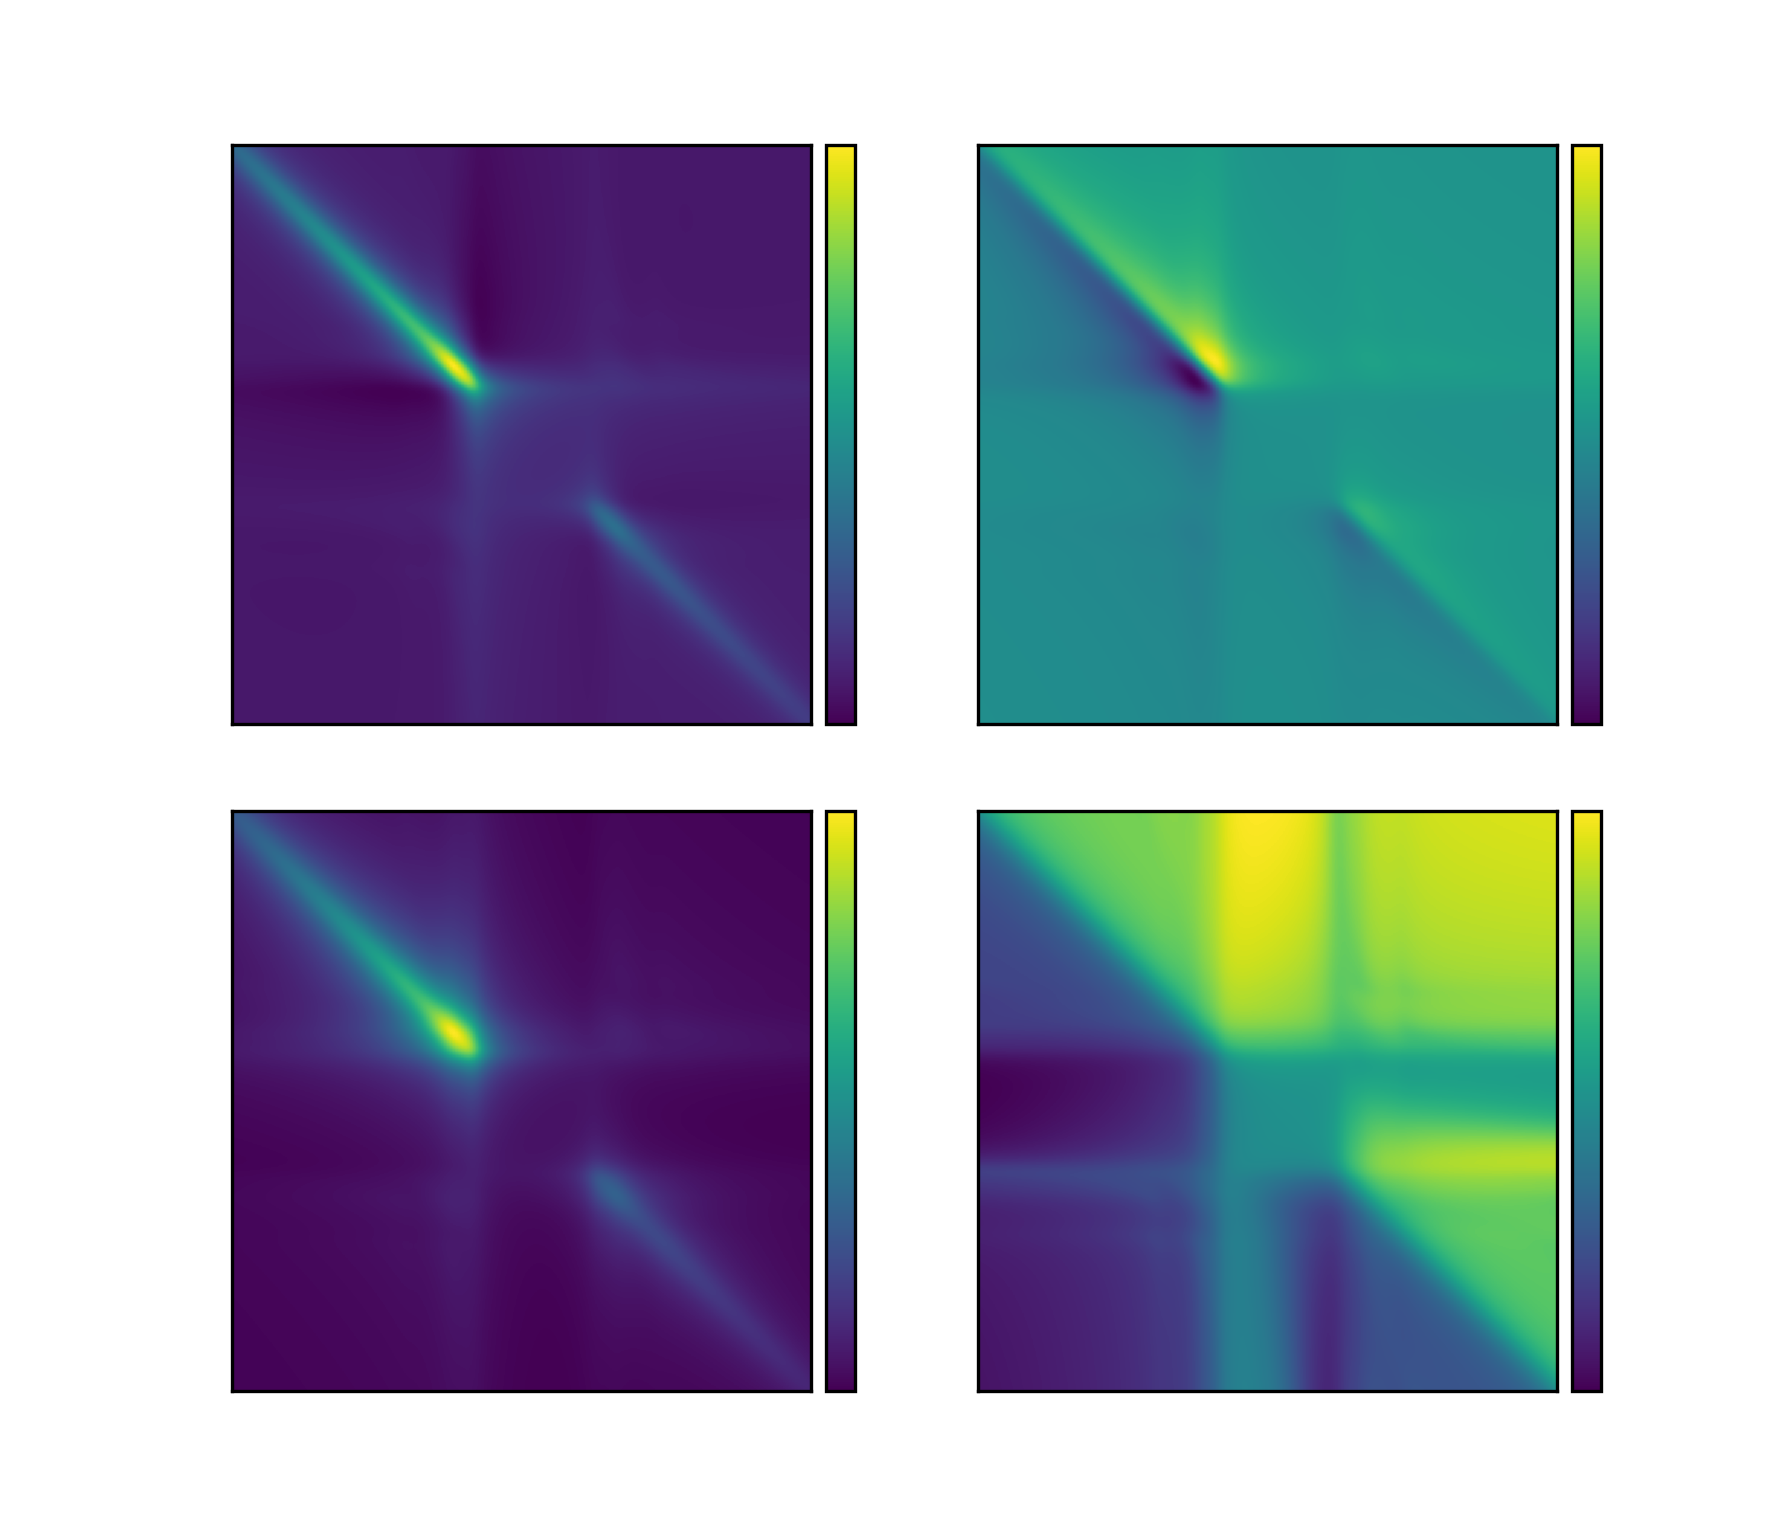

In [52]:
I_uniDir_ReImAmPh = np.array([I_uniDir.real, I_uniDir.imag, np.sqrt(abs2(I_uniDir)), phase(I_uniDir)])
fig_uniDir = slices_plots(I_uniDir_ReImAmPh, 
                      shared_title='Unidirectional ' r'$\epsilon_{yy}$' ' in cystral basis, ' r'$\sigma =$' f'{sigma:.0e}', 
                      shared_title_y_position=0.95,
                      figure_shape=[2,2], 
                      figure_size=[6,5.5],
                      titles=[r'$\mathfrak{R} \left\{I_{uniDir} (\omega_t, \omega_\tau) \right\}$', 
                              r'$\mathfrak{I} \left\{I_{uniDir} (\omega_t, \omega_\tau) \right\}$',
                              r'$             \left |I_{uniDir} (\omega_t, \omega_\tau) \right |$',
                              r'$     \varphi \left\{I_{uniDir} (\omega_t, \omega_\tau) \right\}$'],
                      horizontal_gap=0.15,
                      shared_y_label_x_position=0.02, 
                      shared_x_label_y_position=0.06)